# FINTECH BOOTCAMP - PROJECT 1
## Group 5 Notebook
---
The purpose of the project is to backtest if moving average crossover strategy is efficient over long-term with SPY.

In [1]:
# Initial import all libraries and dependencies
import panel as pn
pn.extension('plotly')
import plotly.express as px
import datetime
import numpy as np
import pandas as pd
import hvplot.pandas
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

### I. DATA FETCHING AND CLEANING

In [2]:
#Define the instruments to download data of a stock/ETF .
tickers = "SPY"

# Fetch SPY Data from 1/1/1992 until 12/31/2021.
start_date = datetime.date(1997,1,1)
end_date = datetime.date(2021,12,31)
interval = '1d'
period = round((end_date - start_date).days/365,0)
if interval == "1d":
    annual_interval = 252

In [3]:
# User pandas_reader.data.DataReader to load the desired data. 
#panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date, interval)
yf.Tickers(tickers)
panel_data = yf.download(tickers, start = start_date, end = end_date, interval = interval)

# Checkout the data type
type(panel_data)

[*********************100%***********************]  1 of 1 completed


pandas.core.frame.DataFrame

In [4]:
# Review data
panel_data

Open        High         Low       Close   Adj Close  \
Date                                                                     
1997-01-02   74.375000   74.375000   72.750000   74.031250   47.419117   
1997-01-03   74.375000   75.125000   74.078125   75.093750   48.099674   
1997-01-06   75.093750   75.437500   74.312500   74.437500   47.679333   
1997-01-07   74.437500   75.468750   74.125000   75.343750   48.259789   
1997-01-08   75.750000   75.781250   74.687500   74.687500   47.839474   
...                ...         ...         ...         ...         ...   
2021-12-23  468.750000  472.190002  468.640015  470.600006  470.600006   
2021-12-27  472.059998  477.309998  472.010010  477.260010  477.260010   
2021-12-28  477.720001  478.809998  476.059998  476.869995  476.869995   
2021-12-29  476.980011  478.559998  475.920013  477.480011  477.480011   
2021-12-30  477.929993  479.000000  475.670013  476.160004  476.160004   

              Volume  
Date                  
1997-01-02   2031900  
1997-01-03   2123200  
1997-01-06   1374100  
1997-01-07    939000  
1997-01-08   1802200  
...              ...  
2021-12-23  56439700  
2021-12-27  56808600  
2021-12-28  47274600  
2021-12-29  54503000  
2021-12-30  55329000  

[6292 rows x 6 columns]

In [5]:
# Select closing price only
price = panel_data[["Close"]]
price.head()

Close
Date                
1997-01-02  74.03125
1997-01-03  75.09375
1997-01-06  74.43750
1997-01-07  75.34375
1997-01-08  74.68750

In [6]:
# Describe data
price.describe()

Close
count  6292.000000
mean    169.140993
std      83.336629
min      68.110001
25%     113.657503
50%     135.360001
75%     207.214996
max     477.480011

In [7]:
# Count nulls and drop nulls (in any)
price.isnull().sum()

Close    0
dtype: int64

In [8]:
# Check if closing price is float 
price.dtypes

Close    float64
dtype: object

### II. Analysis
Calculate total return, compound annual growth rate ('CAGR'), volatility, max drawdown ('MDD'), exposure ratio, number of trade, win rate

#### 1. Buy and Hold Strategy (benchmark)

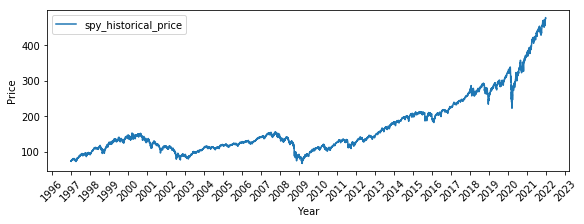

In [9]:
# Plot stock/etf
def chart_bm (strategy_return,title):
    fig = plt.figure(constrained_layout=True, figsize=(8,3)) 
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(strategy_return["Close"],label=title)
    ax.set(xlabel = "Year",
    ylabel = "Price")
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.legend()
    plt.savefig(title, bbox_inches='tight')
    plt.close(fig)
    return fig
chart_bm(price, "spy_historical_price")

In [10]:
# Calculate returns for SPY as a benchmark and compound annual growth rate (CAGR)
bm_daily_return = price [["Close"]]
bm_daily_return = bm_daily_return.pct_change()
bm_daily_return.rename(columns= {"Close" : "bm_daily_return"}, inplace = True)

In [11]:
# Cumulative return
bm_daily_return["bm_cumulative_return"] = (1 + bm_daily_return["bm_daily_return"]).cumprod()
bm_daily_return

bm_daily_return  bm_cumulative_return
Date                                             
1997-01-02              NaN                   NaN
1997-01-03         0.014352              1.014352
1997-01-06        -0.008739              1.005488
1997-01-07         0.012175              1.017729
1997-01-08        -0.008710              1.008864
...                     ...                   ...
2021-12-23         0.006222              6.356775
2021-12-27         0.014152              6.446737
2021-12-28        -0.000817              6.441469
2021-12-29         0.001279              6.449709
2021-12-30        -0.002765              6.431878

[6292 rows x 2 columns]

In [12]:
# Total return and CAGR
total_return_pct = round((bm_daily_return["bm_cumulative_return"].iloc[-1]-1)*100, 2)
cagr_pct = round((((bm_daily_return["bm_cumulative_return"].iloc[-1])**(1/period))-1)*100,2)
print(total_return_pct)
print(cagr_pct)

543.19
7.73


In [13]:
# Calculate standard deviation and sharpe ratio for SPY as a benchmark
bm_volatility_pct = round(bm_daily_return["bm_daily_return"].std()*np.sqrt(annual_interval)*100,2)
bm_volatility_pct

19.74

In [14]:
rf= 0.05
sharpe_ratio = round((cagr_pct-rf)/bm_volatility_pct,2)
sharpe_ratio

0.39

In [15]:
# Calculate benchmark drawdown

In [16]:
bm_daily_return["peak_cumulative"] = bm_daily_return["bm_cumulative_return"].cummax()
bm_daily_return["bm_drawdown_pct"] = ((bm_daily_return["bm_cumulative_return"] - bm_daily_return["peak_cumulative"])/bm_daily_return["peak_cumulative"])*100

In [17]:
# Plot daily drawback - displays portfolio losses from any high point along the way
def bm_dd (title): # drawdown
    fig = plt.figure(constrained_layout=True, figsize=(8,3))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(bm_daily_return["bm_drawdown_pct"],color = "red")
    ax.set(xlabel = "Year",
    ylabel = "Drawdown Percent", title = title)
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.legend()
    plt.savefig(title,bbox_inches='tight')
    plt.close(fig)
    return fig

In [18]:
# Calculate maximum drawdown value
bm_mdd = round(bm_daily_return["bm_drawdown_pct"].min(),2)
bm_mdd

-56.47

In [19]:
df_summary = pd.DataFrame()
index =  ["buy_hold", "strategy_1", "strategy_2", "strategy_3", "strategy_4"]
columns =  ["total_return", "annualized_return", "volatility", "sharpe_ratio", "max_drawdown", "exposure_ratio", "no_of_trade","win_rate" ]
df_summary = pd.DataFrame(columns = columns, index=index)
df_summary

total_return annualized_return volatility sharpe_ratio  \
buy_hold            NaN               NaN        NaN          NaN   
strategy_1          NaN               NaN        NaN          NaN   
strategy_2          NaN               NaN        NaN          NaN   
strategy_3          NaN               NaN        NaN          NaN   
strategy_4          NaN               NaN        NaN          NaN   

           max_drawdown exposure_ratio no_of_trade win_rate  
buy_hold            NaN            NaN         NaN      NaN  
strategy_1          NaN            NaN         NaN      NaN  
strategy_2          NaN            NaN         NaN      NaN  
strategy_3          NaN            NaN         NaN      NaN  
strategy_4          NaN            NaN         NaN      NaN

In [20]:
df_summary.loc["buy_hold"] = pd.Series({ "total_return" : total_return_pct, "annualized_return" : cagr_pct, "volatility" : bm_volatility_pct, 
                                        "sharpe_ratio" : sharpe_ratio, "max_drawdown" : bm_mdd, "exposure_ratio" : 100, "no_of_trade" : 1, "win_rate": 100})
df_summary

total_return annualized_return volatility sharpe_ratio  \
buy_hold         543.19              7.73      19.74         0.39   
strategy_1          NaN               NaN        NaN          NaN   
strategy_2          NaN               NaN        NaN          NaN   
strategy_3          NaN               NaN        NaN          NaN   
strategy_4          NaN               NaN        NaN          NaN   

           max_drawdown exposure_ratio no_of_trade win_rate  
buy_hold         -56.47          100.0         1.0    100.0  
strategy_1          NaN            NaN         NaN      NaN  
strategy_2          NaN            NaN         NaN      NaN  
strategy_3          NaN            NaN         NaN      NaN  
strategy_4          NaN            NaN         NaN      NaN

#### 2. Strategy 1 - Backtesting 50 SMA crossing 200 SMA

In [21]:
fast_ma_1 = 50
slow_ma_1 = 200

In [22]:
# Calculate moving average for Strategy 1
strategy1 = price[["Close"]]
strategy1["fast_ma"] = strategy1["Close"].rolling(window = fast_ma_1).mean()
strategy1["slow_ma"] = strategy1["Close"].rolling(window = slow_ma_1).mean()
strategy1

Close     fast_ma    slow_ma
Date                                         
1997-01-02   74.031250         NaN        NaN
1997-01-03   75.093750         NaN        NaN
1997-01-06   74.437500         NaN        NaN
1997-01-07   75.343750         NaN        NaN
1997-01-08   74.687500         NaN        NaN
...                ...         ...        ...
2021-12-23  470.600006  461.747801  435.16185
2021-12-27  477.260010  462.443001  435.57785
2021-12-28  476.869995  463.063001  435.98015
2021-12-29  477.480011  463.668801  436.38800
2021-12-30  476.160004  464.179201  436.78250

[6292 rows x 3 columns]

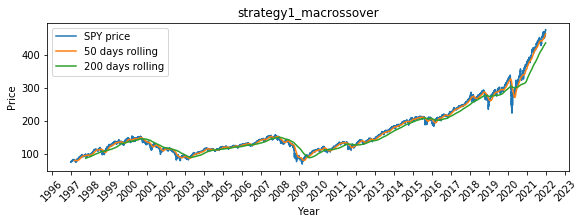

In [23]:
def strategy_plot (strategy,price_label, short_label, long_label,title):
    fig = plt.figure(constrained_layout=True, figsize=(8,3)) 
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(strategy["Close"], label=price_label)
    ax.plot(strategy["fast_ma"], label=short_label)
    ax.plot(strategy["slow_ma"], label=long_label)
    ax.set(xlabel = "Year",
    ylabel = "Price",title = title)
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.legend()
    plt.savefig(title, bbox_inches='tight')
    plt.close(fig)
    return fig
strategy1_plot = strategy_plot(strategy1, 'SPY price', '50 days rolling', 
                               '200 days rolling',"strategy1_macrossover")
strategy1_plot

In [24]:
# Formulate the strategy

In [25]:
benchmark_return = bm_daily_return[["bm_daily_return"]]
strategy1_return = pd.concat([strategy1,benchmark_return],axis=1, join = "inner")
strategy1_return["long_position"] = strategy1_return['fast_ma'] > strategy1_return["slow_ma"]
strategy1_return.head()

Close  fast_ma  slow_ma  bm_daily_return  long_position
Date                                                                  
1997-01-02  74.03125      NaN      NaN              NaN          False
1997-01-03  75.09375      NaN      NaN         0.014352          False
1997-01-06  74.43750      NaN      NaN        -0.008739          False
1997-01-07  75.34375      NaN      NaN         0.012175          False
1997-01-08  74.68750      NaN      NaN        -0.008710          False

In [26]:
strategy1_return["strategy1_return"] = np.where(strategy1_return["long_position"].shift(1) == True, strategy1_return["bm_daily_return"], 0)
strategy1_return.tail()

Close     fast_ma    slow_ma  bm_daily_return  long_position  \
Date                                                                            
2021-12-23  470.600006  461.747801  435.16185         0.006222           True   
2021-12-27  477.260010  462.443001  435.57785         0.014152           True   
2021-12-28  476.869995  463.063001  435.98015        -0.000817           True   
2021-12-29  477.480011  463.668801  436.38800         0.001279           True   
2021-12-30  476.160004  464.179201  436.78250        -0.002765           True   

            strategy1_return  
Date                          
2021-12-23          0.006222  
2021-12-27          0.014152  
2021-12-28         -0.000817  
2021-12-29          0.001279  
2021-12-30         -0.002765

In [27]:
strategy1_return["strategy1_cumulative_return"] = (1+ strategy1_return["strategy1_return"]).cumprod()
strategy1_return

Close     fast_ma    slow_ma  bm_daily_return  long_position  \
Date                                                                            
1997-01-02   74.031250         NaN        NaN              NaN          False   
1997-01-03   75.093750         NaN        NaN         0.014352          False   
1997-01-06   74.437500         NaN        NaN        -0.008739          False   
1997-01-07   75.343750         NaN        NaN         0.012175          False   
1997-01-08   74.687500         NaN        NaN        -0.008710          False   
...                ...         ...        ...              ...            ...   
2021-12-23  470.600006  461.747801  435.16185         0.006222           True   
2021-12-27  477.260010  462.443001  435.57785         0.014152           True   
2021-12-28  476.869995  463.063001  435.98015        -0.000817           True   
2021-12-29  477.480011  463.668801  436.38800         0.001279           True   
2021-12-30  476.160004  464.179201  436.78250        -0.002765           True   

            strategy1_return  strategy1_cumulative_return  
Date                                                       
1997-01-02          0.000000                     1.000000  
1997-01-03          0.000000                     1.000000  
1997-01-06          0.000000                     1.000000  
1997-01-07          0.000000                     1.000000  
1997-01-08          0.000000                     1.000000  
...                      ...                          ...  
2021-12-23          0.006222                     5.057778  
2021-12-27          0.014152                     5.129356  
2021-12-28         -0.000817                     5.125164  
2021-12-29          0.001279                     5.131720  
2021-12-30         -0.002765                     5.117534  

[6292 rows x 7 columns]

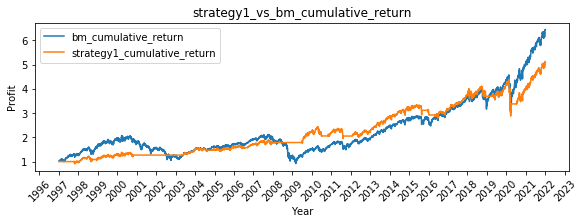

In [28]:
# Plot with the benchmark
# Create a function that can be used to plot any of the graphs based on the strategy return
def strategy_return_plot (bm_daily_return,strategy_return,strategy_label,title):
    fig = plt.figure(constrained_layout=True, figsize=(8,3)) 
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(bm_daily_return["bm_cumulative_return"],label="bm_cumulative_return")
    ax.plot(strategy_return[strategy_label],label=strategy_label)
    ax.set(xlabel = "Year",
    ylabel = "Profit",title = title)
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.legend()
    plt.savefig(title,bbox_inches='tight')
    plt.close(fig)
    return fig
strategy_return_plot(bm_daily_return, strategy1_return, "strategy1_cumulative_return", "strategy1_vs_bm_cumulative_return")

In [29]:
# Calculate strategy total return and CAGR

strategy1_total_return_pct = round((strategy1_return["strategy1_cumulative_return"].iloc[-1]-1) * 100, 2)
strategy1_cagr_pct = round((((strategy1_return["strategy1_cumulative_return"].iloc[-1])**(1/period))-1)*100,2)

In [30]:
print(strategy1_total_return_pct)

411.75


In [31]:
print(strategy1_cagr_pct)

6.75


In [32]:
# Calculate exposure ratio
strategy1_exposure_days = len(strategy1_return["strategy1_return"]) - (strategy1_return["strategy1_return"]==0).sum()
strategy1_exposure_ratio = round(strategy1_exposure_days/len(strategy1_return)*100,2)
print(strategy1_exposure_ratio)

70.28


In [33]:
# Calculate volatility
strategy1_volatility = round(strategy1_return["strategy1_return"].std()*np.sqrt(annual_interval)*100,2)
strategy1_volatility

13.71

In [34]:
rf = 0.05
strategy1_sharpe_ratio = round((strategy1_cagr_pct - rf)/strategy1_volatility,2)
strategy1_sharpe_ratio

0.49

In [35]:
# Calculate drawdown for strategy 1
strategy1_return["strategy1_peak_cumulative"]= strategy1_return["strategy1_cumulative_return"].cummax()
strategy1_return["strategy1_drawdown_pct"] = (strategy1_return["strategy1_cumulative_return"] - strategy1_return["strategy1_peak_cumulative"])/strategy1_return["strategy1_peak_cumulative"]*100
strategy1_return.head()

Close  fast_ma  slow_ma  bm_daily_return  long_position  \
Date                                                                     
1997-01-02  74.03125      NaN      NaN              NaN          False   
1997-01-03  75.09375      NaN      NaN         0.014352          False   
1997-01-06  74.43750      NaN      NaN        -0.008739          False   
1997-01-07  75.34375      NaN      NaN         0.012175          False   
1997-01-08  74.68750      NaN      NaN        -0.008710          False   

            strategy1_return  strategy1_cumulative_return  \
Date                                                        
1997-01-02               0.0                          1.0   
1997-01-03               0.0                          1.0   
1997-01-06               0.0                          1.0   
1997-01-07               0.0                          1.0   
1997-01-08               0.0                          1.0   

            strategy1_peak_cumulative  strategy1_drawdown_pct  
Date                                                           
1997-01-02                        1.0                     0.0  
1997-01-03                        1.0                     0.0  
1997-01-06                        1.0                     0.0  
1997-01-07                        1.0                     0.0  
1997-01-08                        1.0                     0.0

In [36]:
# Plot daily drawback - displays portfolio losses from any high point along the way
def strategy_dd (strategy_return, drawdown_label, title): # drawdown
    fig = plt.figure(constrained_layout=True, figsize=(8,3)) 
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(strategy_return[drawdown_label],color = "red")
    ax.set(xlabel = "Year",
    ylabel = "Drawdown Percent", title = title)
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    #ax.legend()
    plt.savefig(drawdown_label,bbox_inches='tight')
    plt.close(fig)
    return fig
strategy1_dd = strategy_dd(strategy1_return, "strategy1_drawdown_pct", "strategy1_spy_drawdowns")

In [37]:
strategy1_mdd = round(strategy1_return["strategy1_drawdown_pct"].min(),2)
strategy1_mdd

-34.1

In [38]:
# Calculate number of trade and win rate
long_cumulative=[] # the cumulative return at every time when entering the position
size = len(strategy1_return["long_position"])-1
for i in range(size):
    if strategy1_return["long_position"][i] == False and strategy1_return["long_position"][i+1] == True:
        long_cumulative.append(strategy1_return["strategy1_cumulative_return"][i])

In [39]:
strategy1_no_of_trade = len(long_cumulative)
print(strategy1_no_of_trade)

13


In [40]:
strategy1_win = 0
for i in range(len(long_cumulative)-1):
    if long_cumulative[i] < long_cumulative[i+1]:
        strategy1_win+=1

In [41]:
strategy1_win_rate = round(strategy1_win/strategy1_no_of_trade*100,2)
print(strategy1_win_rate)

69.23


In [42]:
# Summary of the strategy1 

In [43]:
df_summary.loc["strategy_1"] = pd.Series({ "total_return" : strategy1_total_return_pct, "annualized_return" : strategy1_cagr_pct, "volatility" : strategy1_volatility, 
                                          "sharpe_ratio" : strategy1_sharpe_ratio, "max_drawdown" : strategy1_mdd, "exposure_ratio" : strategy1_exposure_ratio, "no_of_trade" : strategy1_no_of_trade, "win_rate": strategy1_win_rate})
df_summary

total_return annualized_return volatility sharpe_ratio  \
buy_hold         543.19              7.73      19.74         0.39   
strategy_1       411.75              6.75      13.71         0.49   
strategy_2          NaN               NaN        NaN          NaN   
strategy_3          NaN               NaN        NaN          NaN   
strategy_4          NaN               NaN        NaN          NaN   

           max_drawdown exposure_ratio no_of_trade win_rate  
buy_hold         -56.47          100.0         1.0    100.0  
strategy_1        -34.1          70.28        13.0    69.23  
strategy_2          NaN            NaN         NaN      NaN  
strategy_3          NaN            NaN         NaN      NaN  
strategy_4          NaN            NaN         NaN      NaN

#### 3. Stategy 2 - Backtesting 50 SMA crossing 100 SMA

In [44]:
# Define variables
fast_ma_2 = 50
slow_ma_2 = 100

In [45]:
# Calculate moving average for strategy 2

In [46]:
strategy2 = price[["Close"]]
strategy2['fast_ma'] = strategy2['Close'].rolling(window = fast_ma_2).mean()
strategy2['slow_ma'] = strategy2['Close'].rolling(window = slow_ma_2).mean()
# Observe the values
strategy2

Close     fast_ma     slow_ma
Date                                          
1997-01-02   74.031250         NaN         NaN
1997-01-03   75.093750         NaN         NaN
1997-01-06   74.437500         NaN         NaN
1997-01-07   75.343750         NaN         NaN
1997-01-08   74.687500         NaN         NaN
...                ...         ...         ...
2021-12-23  470.600006  461.747801  452.136101
2021-12-27  477.260010  462.443001  452.518901
2021-12-28  476.869995  463.063001  452.870001
2021-12-29  477.480011  463.668801  453.219901
2021-12-30  476.160004  464.179201  453.560201

[6292 rows x 3 columns]

In [47]:
# Plot a graph
strategy2_plot = strategy_plot(strategy2, 'SPY price', '50 days rolling', '100 days rolling',"strategy2_macrossover")

In [48]:
# Define entries for long position
benchmark_return = bm_daily_return[["bm_daily_return"]]
strategy2_return = pd.concat([strategy2,benchmark_return],axis=1, join = "inner")
strategy2_return["long_position"] = strategy2.fast_ma > strategy2.slow_ma
strategy2_return

Close     fast_ma     slow_ma  bm_daily_return  long_position
Date                                                                          
1997-01-02   74.031250         NaN         NaN              NaN          False
1997-01-03   75.093750         NaN         NaN         0.014352          False
1997-01-06   74.437500         NaN         NaN        -0.008739          False
1997-01-07   75.343750         NaN         NaN         0.012175          False
1997-01-08   74.687500         NaN         NaN        -0.008710          False
...                ...         ...         ...              ...            ...
2021-12-23  470.600006  461.747801  452.136101         0.006222           True
2021-12-27  477.260010  462.443001  452.518901         0.014152           True
2021-12-28  476.869995  463.063001  452.870001        -0.000817           True
2021-12-29  477.480011  463.668801  453.219901         0.001279           True
2021-12-30  476.160004  464.179201  453.560201        -0.002765           True

[6292 rows x 5 columns]

In [49]:
# Calculate the strategy balance
# First calculate the strategy returns
strategy2_return["strategy2_return"] = np.where(strategy2_return["long_position"].shift(1) == True, strategy2_return["bm_daily_return"], 0) 
strategy2_return

Close     fast_ma     slow_ma  bm_daily_return  \
Date                                                              
1997-01-02   74.031250         NaN         NaN              NaN   
1997-01-03   75.093750         NaN         NaN         0.014352   
1997-01-06   74.437500         NaN         NaN        -0.008739   
1997-01-07   75.343750         NaN         NaN         0.012175   
1997-01-08   74.687500         NaN         NaN        -0.008710   
...                ...         ...         ...              ...   
2021-12-23  470.600006  461.747801  452.136101         0.006222   
2021-12-27  477.260010  462.443001  452.518901         0.014152   
2021-12-28  476.869995  463.063001  452.870001        -0.000817   
2021-12-29  477.480011  463.668801  453.219901         0.001279   
2021-12-30  476.160004  464.179201  453.560201        -0.002765   

            long_position  strategy2_return  
Date                                         
1997-01-02          False          0.000000  
1997-01-03          False          0.000000  
1997-01-06          False          0.000000  
1997-01-07          False          0.000000  
1997-01-08          False          0.000000  
...                   ...               ...  
2021-12-23           True          0.006222  
2021-12-27           True          0.014152  
2021-12-28           True         -0.000817  
2021-12-29           True          0.001279  
2021-12-30           True         -0.002765  

[6292 rows x 6 columns]

In [50]:
# Then calculate the strategy balance using the cumulative returns
strategy2_return["strategy2_cumulative_return"] = (1+ strategy2_return["strategy2_return"]).cumprod()
strategy2_return

Close     fast_ma     slow_ma  bm_daily_return  \
Date                                                              
1997-01-02   74.031250         NaN         NaN              NaN   
1997-01-03   75.093750         NaN         NaN         0.014352   
1997-01-06   74.437500         NaN         NaN        -0.008739   
1997-01-07   75.343750         NaN         NaN         0.012175   
1997-01-08   74.687500         NaN         NaN        -0.008710   
...                ...         ...         ...              ...   
2021-12-23  470.600006  461.747801  452.136101         0.006222   
2021-12-27  477.260010  462.443001  452.518901         0.014152   
2021-12-28  476.869995  463.063001  452.870001        -0.000817   
2021-12-29  477.480011  463.668801  453.219901         0.001279   
2021-12-30  476.160004  464.179201  453.560201        -0.002765   

            long_position  strategy2_return  strategy2_cumulative_return  
Date                                                                      
1997-01-02          False          0.000000                     1.000000  
1997-01-03          False          0.000000                     1.000000  
1997-01-06          False          0.000000                     1.000000  
1997-01-07          False          0.000000                     1.000000  
1997-01-08          False          0.000000                     1.000000  
...                   ...               ...                          ...  
2021-12-23           True          0.006222                     3.275295  
2021-12-27           True          0.014152                     3.321647  
2021-12-28           True         -0.000817                     3.318933  
2021-12-29           True          0.001279                     3.323178  
2021-12-30           True         -0.002765                     3.313991  

[6292 rows x 7 columns]

In [51]:
# Plot with the benchmark
strategy2 = strategy_return_plot(bm_daily_return, strategy2_return, "strategy2_cumulative_return","strategy2_vs_bm_cumulative_return")

In [52]:
# Calculate strategy total return and CAGR

strategy2_total_return_pct = round((strategy2_return["strategy2_cumulative_return"].iloc[-1]-1) * 100, 2)
strategy2_cagr_pct = round((((strategy2_return["strategy2_cumulative_return"].iloc[-1])**(1/period))-1)*100,2)

In [53]:
print(strategy2_total_return_pct)

231.4


In [54]:
print(strategy2_cagr_pct)

4.91


In [55]:
# Calculate exposure ratio
strategy2_exposure_days = len(strategy2_return["strategy2_return"]) - (strategy2_return["strategy2_return"]==0).sum()
strategy2_exposure_ratio = round(strategy2_exposure_days/len(strategy2_return)*100,2)
print(strategy2_exposure_ratio)

68.96


In [56]:
# Calculate volatility
strategy2_volatility = round(strategy2_return["strategy2_return"].std()*np.sqrt(annual_interval)*100,2)
strategy2_volatility

13.34

In [57]:
strategy2_sharpe_ratio = round((strategy2_cagr_pct - rf)/strategy2_volatility,2)
strategy2_sharpe_ratio

0.36

In [58]:
# Calculate drawdown for strategy 2
strategy2_return["strategy2_peak_cumulative"]= strategy2_return["strategy2_cumulative_return"].cummax()
strategy2_return["strategy2_drawdown_pct"] = (strategy2_return["strategy2_cumulative_return"] - strategy2_return["strategy2_peak_cumulative"])/strategy2_return["strategy2_peak_cumulative"]*100
strategy2_return

Close     fast_ma     slow_ma  bm_daily_return  \
Date                                                              
1997-01-02   74.031250         NaN         NaN              NaN   
1997-01-03   75.093750         NaN         NaN         0.014352   
1997-01-06   74.437500         NaN         NaN        -0.008739   
1997-01-07   75.343750         NaN         NaN         0.012175   
1997-01-08   74.687500         NaN         NaN        -0.008710   
...                ...         ...         ...              ...   
2021-12-23  470.600006  461.747801  452.136101         0.006222   
2021-12-27  477.260010  462.443001  452.518901         0.014152   
2021-12-28  476.869995  463.063001  452.870001        -0.000817   
2021-12-29  477.480011  463.668801  453.219901         0.001279   
2021-12-30  476.160004  464.179201  453.560201        -0.002765   

            long_position  strategy2_return  strategy2_cumulative_return  \
Date                                                                       
1997-01-02          False          0.000000                     1.000000   
1997-01-03          False          0.000000                     1.000000   
1997-01-06          False          0.000000                     1.000000   
1997-01-07          False          0.000000                     1.000000   
1997-01-08          False          0.000000                     1.000000   
...                   ...               ...                          ...   
2021-12-23           True          0.006222                     3.275295   
2021-12-27           True          0.014152                     3.321647   
2021-12-28           True         -0.000817                     3.318933   
2021-12-29           True          0.001279                     3.323178   
2021-12-30           True         -0.002765                     3.313991   

            strategy2_peak_cumulative  strategy2_drawdown_pct  
Date                                                           
1997-01-02                   1.000000                0.000000  
1997-01-03                   1.000000                0.000000  
1997-01-06                   1.000000                0.000000  
1997-01-07                   1.000000                0.000000  
1997-01-08                   1.000000                0.000000  
...                               ...                     ...  
2021-12-23                   3.276269               -0.029737  
2021-12-27                   3.321647                0.000000  
2021-12-28                   3.321647               -0.081720  
2021-12-29                   3.323178                0.000000  
2021-12-30                   3.323178               -0.276453  

[6292 rows x 9 columns]

In [59]:
# Plot daily drawback - displays portfolio losses from any high point along the way
strategy2_dd = strategy_dd(strategy2_return, "strategy2_drawdown_pct", "strategy2_spy_drawdowns")

In [60]:
strategy2_mdd = round(strategy2_return["strategy2_drawdown_pct"].min(),2)
strategy2_mdd

-31.59

In [61]:
# Calculate number of trade and win rate
long_cumulative=[] # the cumulative return at every time when entering the position
size = len(strategy2_return["long_position"])-1
for i in range(size):
    if strategy2_return["long_position"][i] == False and strategy2_return["long_position"][i+1] == True:
        long_cumulative.append(strategy2_return["strategy2_cumulative_return"][i])

In [62]:
strategy2_no_of_trade = len(long_cumulative)
print(strategy2_no_of_trade)

26


In [63]:
strategy2_win = 0
for i in range(len(long_cumulative)-1):
    if long_cumulative[i] < long_cumulative[i+1]:
        strategy2_win+=1

In [64]:
strategy2_win_rate = round(strategy2_win/strategy2_no_of_trade*100,2)
print(strategy2_win_rate)

50.0


In [65]:
# Summary of the strategy 2 

In [66]:
df_summary.loc["strategy_2"] = pd.Series({ "total_return" : strategy2_total_return_pct, "annualized_return" : strategy2_cagr_pct, "volatility" : strategy2_volatility, 
                                           "sharpe_ratio" : strategy2_sharpe_ratio, "max_drawdown" : strategy2_mdd, "exposure_ratio" : strategy2_exposure_ratio, "no_of_trade" : strategy2_no_of_trade, "win_rate": strategy2_win_rate})
df_summary

total_return annualized_return volatility sharpe_ratio  \
buy_hold         543.19              7.73      19.74         0.39   
strategy_1       411.75              6.75      13.71         0.49   
strategy_2        231.4              4.91      13.34         0.36   
strategy_3          NaN               NaN        NaN          NaN   
strategy_4          NaN               NaN        NaN          NaN   

           max_drawdown exposure_ratio no_of_trade win_rate  
buy_hold         -56.47          100.0         1.0    100.0  
strategy_1        -34.1          70.28        13.0    69.23  
strategy_2       -31.59          68.96        26.0     50.0  
strategy_3          NaN            NaN         NaN      NaN  
strategy_4          NaN            NaN         NaN      NaN

#### 3. Strategy 3 - Backtesting 20 EMA crossing 50 SMA 

In [67]:
# Define variables
fast_ma_3 = 20
slow_ma_3 = 50

In [68]:
# Calculate moving average for strategy 3

In [69]:
strategy3 = price[["Close"]]
strategy3['fast_ma'] = strategy3['Close'].ewm(span = fast_ma_3, adjust = False).mean()
strategy3['slow_ma'] = strategy3['Close'].rolling(window = slow_ma_3).mean()
strategy3

Close     fast_ma     slow_ma
Date                                          
1997-01-02   74.031250   74.031250         NaN
1997-01-03   75.093750   74.132440         NaN
1997-01-06   74.437500   74.161494         NaN
1997-01-07   75.343750   74.274090         NaN
1997-01-08   74.687500   74.313462         NaN
...                ...         ...         ...
2021-12-23  470.600006  464.256297  461.747801
2021-12-27  477.260010  465.494746  462.443001
2021-12-28  476.869995  466.578103  463.063001
2021-12-29  477.480011  467.616380  463.668801
2021-12-30  476.160004  468.430058  464.179201

[6292 rows x 3 columns]

In [70]:
# Plot a graph
strategy3_plot = strategy_plot(strategy3, 'SPY price', '20 days rolling', '50 days rolling',"strategy_3_macrossover")

In [71]:
# Define entries for long position
benchmark_return = bm_daily_return[["bm_daily_return"]]
strategy3_return = pd.concat([strategy3,benchmark_return],axis=1, join = "inner")
strategy3_return["long_position"] = strategy3.fast_ma > strategy3.slow_ma
strategy3_return

Close     fast_ma     slow_ma  bm_daily_return  long_position
Date                                                                          
1997-01-02   74.031250   74.031250         NaN              NaN          False
1997-01-03   75.093750   74.132440         NaN         0.014352          False
1997-01-06   74.437500   74.161494         NaN        -0.008739          False
1997-01-07   75.343750   74.274090         NaN         0.012175          False
1997-01-08   74.687500   74.313462         NaN        -0.008710          False
...                ...         ...         ...              ...            ...
2021-12-23  470.600006  464.256297  461.747801         0.006222           True
2021-12-27  477.260010  465.494746  462.443001         0.014152           True
2021-12-28  476.869995  466.578103  463.063001        -0.000817           True
2021-12-29  477.480011  467.616380  463.668801         0.001279           True
2021-12-30  476.160004  468.430058  464.179201        -0.002765           True

[6292 rows x 5 columns]

In [72]:
# Calculate the strategy balance
# First calculate the strategy returns
strategy3_return["strategy3_return"] = np.where(strategy3_return["long_position"].shift(1) == True, strategy3_return["bm_daily_return"], 0) 
strategy3_return

Close     fast_ma     slow_ma  bm_daily_return  \
Date                                                              
1997-01-02   74.031250   74.031250         NaN              NaN   
1997-01-03   75.093750   74.132440         NaN         0.014352   
1997-01-06   74.437500   74.161494         NaN        -0.008739   
1997-01-07   75.343750   74.274090         NaN         0.012175   
1997-01-08   74.687500   74.313462         NaN        -0.008710   
...                ...         ...         ...              ...   
2021-12-23  470.600006  464.256297  461.747801         0.006222   
2021-12-27  477.260010  465.494746  462.443001         0.014152   
2021-12-28  476.869995  466.578103  463.063001        -0.000817   
2021-12-29  477.480011  467.616380  463.668801         0.001279   
2021-12-30  476.160004  468.430058  464.179201        -0.002765   

            long_position  strategy3_return  
Date                                         
1997-01-02          False          0.000000  
1997-01-03          False          0.000000  
1997-01-06          False          0.000000  
1997-01-07          False          0.000000  
1997-01-08          False          0.000000  
...                   ...               ...  
2021-12-23           True          0.006222  
2021-12-27           True          0.014152  
2021-12-28           True         -0.000817  
2021-12-29           True          0.001279  
2021-12-30           True         -0.002765  

[6292 rows x 6 columns]

In [73]:
# Then calculate the strategy balance using the cumulative returns
strategy3_return["strategy3_cumulative_return"] = (1+ strategy3_return["strategy3_return"]).cumprod()
strategy3_return

Close     fast_ma     slow_ma  bm_daily_return  \
Date                                                              
1997-01-02   74.031250   74.031250         NaN              NaN   
1997-01-03   75.093750   74.132440         NaN         0.014352   
1997-01-06   74.437500   74.161494         NaN        -0.008739   
1997-01-07   75.343750   74.274090         NaN         0.012175   
1997-01-08   74.687500   74.313462         NaN        -0.008710   
...                ...         ...         ...              ...   
2021-12-23  470.600006  464.256297  461.747801         0.006222   
2021-12-27  477.260010  465.494746  462.443001         0.014152   
2021-12-28  476.869995  466.578103  463.063001        -0.000817   
2021-12-29  477.480011  467.616380  463.668801         0.001279   
2021-12-30  476.160004  468.430058  464.179201        -0.002765   

            long_position  strategy3_return  strategy3_cumulative_return  
Date                                                                      
1997-01-02          False          0.000000                     1.000000  
1997-01-03          False          0.000000                     1.000000  
1997-01-06          False          0.000000                     1.000000  
1997-01-07          False          0.000000                     1.000000  
1997-01-08          False          0.000000                     1.000000  
...                   ...               ...                          ...  
2021-12-23           True          0.006222                     2.061847  
2021-12-27           True          0.014152                     2.091026  
2021-12-28           True         -0.000817                     2.089318  
2021-12-29           True          0.001279                     2.091990  
2021-12-30           True         -0.002765                     2.086207  

[6292 rows x 7 columns]

In [74]:
# Plot with the benchmark
strategy3 = strategy_return_plot(bm_daily_return, strategy3_return, "strategy3_cumulative_return","strategy3_vs_bm_cumulative_return")

In [75]:
# Calculate strategy total return and CAGR

strategy3_total_return_pct = round((strategy3_return["strategy3_cumulative_return"].iloc[-1]-1) * 100, 2)
strategy3_cagr_pct = round((((strategy3_return["strategy3_cumulative_return"].iloc[-1])**(1/period))-1)*100,2)

In [76]:
print(strategy3_total_return_pct)

108.62


In [77]:
print(strategy3_cagr_pct)

2.99


In [78]:
# Calculate exposure ratio
strategy3_exposure_days = len(strategy3_return["strategy3_return"]) - (strategy3_return["strategy3_return"]==0).sum()
strategy3_exposure_ratio = round(strategy3_exposure_days/len(strategy3_return)*100,2)
print(strategy3_exposure_ratio)

65.0


In [79]:
# Calculate volatility
strategy3_volatility = round(strategy3_return["strategy3_return"].std()*np.sqrt(annual_interval)*100,2)
strategy3_volatility

11.77

In [80]:
strategy3_sharpe_ratio = round((strategy3_cagr_pct - rf)/strategy3_volatility,2)
strategy3_sharpe_ratio

0.25

In [81]:
# Calculate drawdown for strategy 3
strategy3_return["strategy3_peak_cumulative"]= strategy3_return["strategy3_cumulative_return"].cummax()
strategy3_return["strategy3_drawdown_pct"] = (strategy3_return["strategy3_cumulative_return"] - strategy3_return["strategy3_peak_cumulative"])/strategy3_return["strategy3_peak_cumulative"]*100
strategy3_return

Close     fast_ma     slow_ma  bm_daily_return  \
Date                                                              
1997-01-02   74.031250   74.031250         NaN              NaN   
1997-01-03   75.093750   74.132440         NaN         0.014352   
1997-01-06   74.437500   74.161494         NaN        -0.008739   
1997-01-07   75.343750   74.274090         NaN         0.012175   
1997-01-08   74.687500   74.313462         NaN        -0.008710   
...                ...         ...         ...              ...   
2021-12-23  470.600006  464.256297  461.747801         0.006222   
2021-12-27  477.260010  465.494746  462.443001         0.014152   
2021-12-28  476.869995  466.578103  463.063001        -0.000817   
2021-12-29  477.480011  467.616380  463.668801         0.001279   
2021-12-30  476.160004  468.430058  464.179201        -0.002765   

            long_position  strategy3_return  strategy3_cumulative_return  \
Date                                                                       
1997-01-02          False          0.000000                     1.000000   
1997-01-03          False          0.000000                     1.000000   
1997-01-06          False          0.000000                     1.000000   
1997-01-07          False          0.000000                     1.000000   
1997-01-08          False          0.000000                     1.000000   
...                   ...               ...                          ...   
2021-12-23           True          0.006222                     2.061847   
2021-12-27           True          0.014152                     2.091026   
2021-12-28           True         -0.000817                     2.089318   
2021-12-29           True          0.001279                     2.091990   
2021-12-30           True         -0.002765                     2.086207   

            strategy3_peak_cumulative  strategy3_drawdown_pct  
Date                                                           
1997-01-02                   1.000000                0.000000  
1997-01-03                   1.000000                0.000000  
1997-01-06                   1.000000                0.000000  
1997-01-07                   1.000000                0.000000  
1997-01-08                   1.000000                0.000000  
...                               ...                     ...  
2021-12-23                   2.074381               -0.604246  
2021-12-27                   2.091026                0.000000  
2021-12-28                   2.091026               -0.081720  
2021-12-29                   2.091990                0.000000  
2021-12-30                   2.091990               -0.276453  

[6292 rows x 9 columns]

In [82]:
# Plot daily drawback - displays portfolio losses from any high point along the way
strategy3_dd = strategy_dd(strategy3_return, "strategy3_drawdown_pct", "strategy3_spy_drawdowns")

In [83]:
strategy3_mdd = round(strategy3_return["strategy3_drawdown_pct"].min(),2)
strategy3_mdd

-39.83

In [84]:
# Calculate number of trade and win rate
long_cumulative=[] # the cumulative return at every time when entering the position
size = len(strategy3_return["long_position"])-1
for i in range(size):
    if strategy3_return["long_position"][i] == False and strategy3_return["long_position"][i+1] == True:
        long_cumulative.append(strategy3_return["strategy3_cumulative_return"][i])

In [85]:
strategy3_no_of_trade = len(long_cumulative)
print(strategy3_no_of_trade)

70


In [86]:
strategy3_win = 0
for i in range(len(long_cumulative)-1):
    if long_cumulative[i] < long_cumulative[i+1]:
        strategy3_win+=1

In [87]:
strategy3_win_rate = round(strategy3_win/strategy3_no_of_trade*100,2)
print(strategy3_win_rate)

45.71


In [88]:
# Summary of the strategy 3 

In [89]:
df_summary.loc["strategy_3"] = pd.Series({ "total_return" : strategy3_total_return_pct, "annualized_return" : strategy3_cagr_pct, "volatility" : strategy3_volatility, 
                                          "sharpe_ratio" : strategy3_sharpe_ratio, "max_drawdown" : strategy3_mdd, "exposure_ratio" : strategy3_exposure_ratio, "no_of_trade" : strategy3_no_of_trade, 
                                          "win_rate": strategy3_win_rate})
df_summary

total_return annualized_return volatility sharpe_ratio  \
buy_hold         543.19              7.73      19.74         0.39   
strategy_1       411.75              6.75      13.71         0.49   
strategy_2        231.4              4.91      13.34         0.36   
strategy_3       108.62              2.99      11.77         0.25   
strategy_4          NaN               NaN        NaN          NaN   

           max_drawdown exposure_ratio no_of_trade win_rate  
buy_hold         -56.47          100.0         1.0    100.0  
strategy_1        -34.1          70.28        13.0    69.23  
strategy_2       -31.59          68.96        26.0     50.0  
strategy_3       -39.83           65.0        70.0    45.71  
strategy_4          NaN            NaN         NaN      NaN

#### 4. Strategy 4 - Backtesting 11 EMA crossing the 49 EMA

In [90]:
# Define variables
fast_ma_4 = 11
slow_ma_4 = 49

In [91]:
# Calculate moving average for strategy 4

In [92]:
strategy4 = price[["Close"]]
strategy4['fast_ma'] = strategy4['Close'].ewm(span = fast_ma_4, adjust = False).mean()
strategy4['slow_ma'] = strategy4["Close"].ewm(span=slow_ma_4, adjust=False).mean()
strategy4

Close     fast_ma     slow_ma
Date                                          
1997-01-02   74.031250   74.031250   74.031250
1997-01-03   75.093750   74.208333   74.073750
1997-01-06   74.437500   74.246528   74.088300
1997-01-07   75.343750   74.429398   74.138518
1997-01-08   74.687500   74.472415   74.160477
...                ...         ...         ...
2021-12-23  470.600006  464.982367  460.243014
2021-12-27  477.260010  467.028641  460.923694
2021-12-28  476.869995  468.668866  461.561546
2021-12-29  477.480011  470.137390  462.198284
2021-12-30  476.160004  471.141159  462.756753

[6292 rows x 3 columns]

In [93]:
# Plot a graph
strategy4_plot = strategy_plot(strategy4, 'SPY price', '11 days rolling', '49 days rolling',"strategy4_macrossover")

In [94]:
# Define entries for long position
benchmark_return = bm_daily_return[["bm_daily_return"]]
strategy4_return = pd.concat([strategy4,benchmark_return],axis=1, join = "inner")
strategy4_return["long_position"] = strategy4.fast_ma > strategy4.slow_ma
strategy4_return

Close     fast_ma     slow_ma  bm_daily_return  long_position
Date                                                                          
1997-01-02   74.031250   74.031250   74.031250              NaN          False
1997-01-03   75.093750   74.208333   74.073750         0.014352           True
1997-01-06   74.437500   74.246528   74.088300        -0.008739           True
1997-01-07   75.343750   74.429398   74.138518         0.012175           True
1997-01-08   74.687500   74.472415   74.160477        -0.008710           True
...                ...         ...         ...              ...            ...
2021-12-23  470.600006  464.982367  460.243014         0.006222           True
2021-12-27  477.260010  467.028641  460.923694         0.014152           True
2021-12-28  476.869995  468.668866  461.561546        -0.000817           True
2021-12-29  477.480011  470.137390  462.198284         0.001279           True
2021-12-30  476.160004  471.141159  462.756753        -0.002765           True

[6292 rows x 5 columns]

In [95]:
# Calculate the strategy balance
# First calculate the strategy returns
strategy4_return["strategy4_return"] = np.where(strategy4_return["long_position"].shift(1) == True, strategy4_return["bm_daily_return"], 0) 
strategy4_return

Close     fast_ma     slow_ma  bm_daily_return  \
Date                                                              
1997-01-02   74.031250   74.031250   74.031250              NaN   
1997-01-03   75.093750   74.208333   74.073750         0.014352   
1997-01-06   74.437500   74.246528   74.088300        -0.008739   
1997-01-07   75.343750   74.429398   74.138518         0.012175   
1997-01-08   74.687500   74.472415   74.160477        -0.008710   
...                ...         ...         ...              ...   
2021-12-23  470.600006  464.982367  460.243014         0.006222   
2021-12-27  477.260010  467.028641  460.923694         0.014152   
2021-12-28  476.869995  468.668866  461.561546        -0.000817   
2021-12-29  477.480011  470.137390  462.198284         0.001279   
2021-12-30  476.160004  471.141159  462.756753        -0.002765   

            long_position  strategy4_return  
Date                                         
1997-01-02          False          0.000000  
1997-01-03           True          0.000000  
1997-01-06           True         -0.008739  
1997-01-07           True          0.012175  
1997-01-08           True         -0.008710  
...                   ...               ...  
2021-12-23           True          0.006222  
2021-12-27           True          0.014152  
2021-12-28           True         -0.000817  
2021-12-29           True          0.001279  
2021-12-30           True         -0.002765  

[6292 rows x 6 columns]

In [96]:
# Then calculate the strategy balance using the cumulative returns
strategy4_return["strategy4_cumulative_return"] = (1+ strategy4_return["strategy4_return"]).cumprod()
strategy4_return

Close     fast_ma     slow_ma  bm_daily_return  \
Date                                                              
1997-01-02   74.031250   74.031250   74.031250              NaN   
1997-01-03   75.093750   74.208333   74.073750         0.014352   
1997-01-06   74.437500   74.246528   74.088300        -0.008739   
1997-01-07   75.343750   74.429398   74.138518         0.012175   
1997-01-08   74.687500   74.472415   74.160477        -0.008710   
...                ...         ...         ...              ...   
2021-12-23  470.600006  464.982367  460.243014         0.006222   
2021-12-27  477.260010  467.028641  460.923694         0.014152   
2021-12-28  476.869995  468.668866  461.561546        -0.000817   
2021-12-29  477.480011  470.137390  462.198284         0.001279   
2021-12-30  476.160004  471.141159  462.756753        -0.002765   

            long_position  strategy4_return  strategy4_cumulative_return  
Date                                                                      
1997-01-02          False          0.000000                     1.000000  
1997-01-03           True          0.000000                     1.000000  
1997-01-06           True         -0.008739                     0.991261  
1997-01-07           True          0.012175                     1.003329  
1997-01-08           True         -0.008710                     0.994590  
...                   ...               ...                          ...  
2021-12-23           True          0.006222                     3.258521  
2021-12-27           True          0.014152                     3.304636  
2021-12-28           True         -0.000817                     3.301936  
2021-12-29           True          0.001279                     3.306159  
2021-12-30           True         -0.002765                     3.297019  

[6292 rows x 7 columns]

In [97]:
# Plot with the benchmark
strategy4 = strategy_return_plot(bm_daily_return, strategy4_return, "strategy4_cumulative_return","strategy4_vs_bm_cumulative_return")

In [98]:
# Calculate strategy total return and CAGR
strategy4_total_return_pct = round((strategy4_return["strategy4_cumulative_return"].iloc[-1]-1) * 100, 2)
strategy4_cagr_pct = round((((strategy4_return["strategy4_cumulative_return"].iloc[-1])**(1/period))-1)*100,2)

In [99]:
print(strategy4_total_return_pct)

229.7


In [100]:
print(strategy4_cagr_pct)

4.89


In [101]:
# Calculate exposure ratio
strategy4_exposure_days = len(strategy4_return["strategy4_return"]) - (strategy4_return["strategy4_return"]==0).sum()
strategy4_exposure_ratio = round(strategy4_exposure_days/len(strategy4_return)*100,2)
print(strategy4_exposure_ratio)

68.6


In [102]:
# Calculate volatility
strategy4_volatility = round(strategy4_return["strategy4_return"].std()*np.sqrt(annual_interval)*100,2)
strategy4_volatility

11.77

In [103]:
strategy4_sharpe_ratio = round((strategy4_cagr_pct - rf)/strategy4_volatility,2)
strategy4_sharpe_ratio

0.41

In [104]:
# Calculate drawdown for strategy 4
strategy4_return["strategy4_peak_cumulative"]= strategy4_return["strategy4_cumulative_return"].cummax()
strategy4_return["strategy4_drawdown_pct"] = (strategy4_return["strategy4_cumulative_return"] - strategy4_return["strategy4_peak_cumulative"])/strategy4_return["strategy4_peak_cumulative"]*100
strategy4_return

Close     fast_ma     slow_ma  bm_daily_return  \
Date                                                              
1997-01-02   74.031250   74.031250   74.031250              NaN   
1997-01-03   75.093750   74.208333   74.073750         0.014352   
1997-01-06   74.437500   74.246528   74.088300        -0.008739   
1997-01-07   75.343750   74.429398   74.138518         0.012175   
1997-01-08   74.687500   74.472415   74.160477        -0.008710   
...                ...         ...         ...              ...   
2021-12-23  470.600006  464.982367  460.243014         0.006222   
2021-12-27  477.260010  467.028641  460.923694         0.014152   
2021-12-28  476.869995  468.668866  461.561546        -0.000817   
2021-12-29  477.480011  470.137390  462.198284         0.001279   
2021-12-30  476.160004  471.141159  462.756753        -0.002765   

            long_position  strategy4_return  strategy4_cumulative_return  \
Date                                                                       
1997-01-02          False          0.000000                     1.000000   
1997-01-03           True          0.000000                     1.000000   
1997-01-06           True         -0.008739                     0.991261   
1997-01-07           True          0.012175                     1.003329   
1997-01-08           True         -0.008710                     0.994590   
...                   ...               ...                          ...   
2021-12-23           True          0.006222                     3.258521   
2021-12-27           True          0.014152                     3.304636   
2021-12-28           True         -0.000817                     3.301936   
2021-12-29           True          0.001279                     3.306159   
2021-12-30           True         -0.002765                     3.297019   

            strategy4_peak_cumulative  strategy4_drawdown_pct  
Date                                                           
1997-01-02                   1.000000                0.000000  
1997-01-03                   1.000000                0.000000  
1997-01-06                   1.000000               -0.873908  
1997-01-07                   1.003329                0.000000  
1997-01-08                   1.003329               -0.871008  
...                               ...                     ...  
2021-12-23                   3.259490               -0.029737  
2021-12-27                   3.304636                0.000000  
2021-12-28                   3.304636               -0.081720  
2021-12-29                   3.306159                0.000000  
2021-12-30                   3.306159               -0.276453  

[6292 rows x 9 columns]

In [105]:
# Plot daily drawback - displays portfolio losses from any high point along the way
strategy4_dd = strategy_dd(strategy4_return, "strategy4_drawdown_pct", "strategy4_spy_drawdowns")

In [106]:
strategy4_mdd = round(strategy4_return["strategy4_drawdown_pct"].min(),2)
strategy4_mdd

-40.12

In [107]:
# Calculate number of trade and win rate
long_cumulative=[] # the cumulative return at every time when entering the position
size = len(strategy4_return["long_position"])-1
for i in range(size):
    if strategy4_return["long_position"][i] == False and strategy4_return["long_position"][i+1] == True:
        long_cumulative.append(strategy4_return["strategy4_cumulative_return"][i])

In [108]:
strategy4_no_of_trade = len(long_cumulative)
print(strategy4_no_of_trade)

73


In [109]:
strategy4_win = 0
for i in range(len(long_cumulative)-1):
    if long_cumulative[i] < long_cumulative[i+1]:
        strategy4_win+=1

In [110]:
strategy4_win_rate = round(strategy4_win/strategy4_no_of_trade*100,2)
print(strategy4_win_rate)

38.36


In [111]:
# Summary of the strategy 4

In [112]:
df_summary.loc["strategy_4"] = pd.Series({ "total_return" : strategy4_total_return_pct, "annualized_return" : strategy4_cagr_pct, "volatility" : strategy4_volatility, 
                                           "sharpe_ratio" : strategy4_sharpe_ratio,"max_drawdown" : strategy4_mdd, "exposure_ratio" : strategy4_exposure_ratio, "no_of_trade" : strategy4_no_of_trade, 
                                          "win_rate": strategy4_win_rate})
df_summary

total_return annualized_return volatility sharpe_ratio  \
buy_hold         543.19              7.73      19.74         0.39   
strategy_1       411.75              6.75      13.71         0.49   
strategy_2        231.4              4.91      13.34         0.36   
strategy_3       108.62              2.99      11.77         0.25   
strategy_4        229.7              4.89      11.77         0.41   

           max_drawdown exposure_ratio no_of_trade win_rate  
buy_hold         -56.47          100.0         1.0    100.0  
strategy_1        -34.1          70.28        13.0    69.23  
strategy_2       -31.59          68.96        26.0     50.0  
strategy_3       -39.83           65.0        70.0    45.71  
strategy_4       -40.12           68.6        73.0    38.36

## IV. COMPARISON AMONG DIFFERENT STRATEGIES

In [113]:
# Consolidate all data
df_summary.reset_index
df_summary.reset_index(inplace=True)

In [114]:
df_summary.rename(columns={'index': 'strategy'})

strategy total_return annualized_return volatility sharpe_ratio  \
0    buy_hold       543.19              7.73      19.74         0.39   
1  strategy_1       411.75              6.75      13.71         0.49   
2  strategy_2        231.4              4.91      13.34         0.36   
3  strategy_3       108.62              2.99      11.77         0.25   
4  strategy_4        229.7              4.89      11.77         0.41   

  max_drawdown exposure_ratio no_of_trade win_rate  
0       -56.47          100.0         1.0    100.0  
1        -34.1          70.28        13.0    69.23  
2       -31.59          68.96        26.0     50.0  
3       -39.83           65.0        70.0    45.71  
4       -40.12           68.6        73.0    38.36

In [115]:
table_overview = df_summary.hvplot.table(sortable=True, selectable=True, width=1000, height=200)

In [116]:
# Plot the final outcome
# Define function
def strategy_comp_return_plot (bm_daily_return,strategy1_return,strategy_label1,strategy2_return,strategy_label2,strategy3_return,strategy_label3,strategy4_return,strategy_label4,title):
    fig = plt.figure(constrained_layout=True, figsize=(8,3)) 
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(bm_daily_return["bm_cumulative_return"],label="bm_cumulative_return")
    ax.plot(strategy1_return[strategy_label1],label=strategy_label1)
    ax.plot(strategy2_return[strategy_label2],label=strategy_label2)
    ax.plot(strategy3_return[strategy_label3],label=strategy_label3)
    ax.plot(strategy4_return[strategy_label4],label=strategy_label4)
    ax.set(xlabel = "Year",
    ylabel = "Profit",title = title)
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.legend()
    plt.savefig(title,bbox_inches='tight')
    plt.close(fig)
    return fig
strategies_returns = strategy_comp_return_plot(bm_daily_return, strategy1_return, "strategy1_cumulative_return",strategy2_return, "strategy2_cumulative_return", 
                     strategy3_return, "strategy3_cumulative_return", strategy4_return, "strategy4_cumulative_return", "comparison_cumulative_returns")

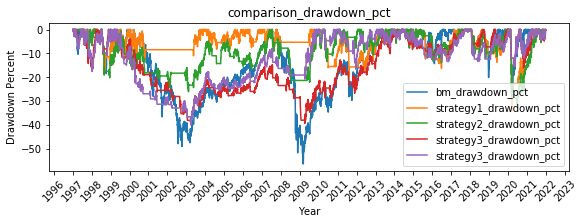

In [117]:
def strategy_dd (title): # drawdown
    fig = plt.figure(constrained_layout=True, figsize=(8,3)) 
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(bm_daily_return["bm_drawdown_pct"], label = "bm_drawdown_pct")
    ax.plot(strategy1_return["strategy1_drawdown_pct"], label = "strategy1_drawdown_pct")
    ax.plot(strategy2_return["strategy2_drawdown_pct"], label = "strategy2_drawdown_pct")
    ax.plot(strategy3_return["strategy3_drawdown_pct"], label = "strategy3_drawdown_pct")
    ax.plot(strategy4_return["strategy4_drawdown_pct"], label = "strategy3_drawdown_pct")
    ax.set(xlabel = "Year",
    ylabel = "Drawdown Percent",title = title)
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.legend()
    plt.savefig(title,bbox_inches='tight')
    plt.close(fig)
    return fig
strategies_dd = strategy_dd("comparison_drawdown_pct")
strategies_dd

## V. REPORT DASHBOARD

In [118]:
# Create a Title for the Dashboard
title = "# BACKTESTING MA CROSSOVER WITH SPY OVER 25 YEARS "

# Define a welcome text
welcome_text = ("#### This dashboard provides an overview backtesting result of four differnent ma strategies (different intervals) vs buy and hold. Strategy1: 50 SMA crossing 200 SMA; Stategy2 : 50 SMA crossing 100 SMA ;Stategy3: 20 EMA crossing 50 SMA; Strategy4: 11 EMA crossing the 49 EMA") 
                 

In [119]:
# Put the stock/etf and its daily drawback chart in rows
stock_row = pn.Row(chart_bm(price, "spy_historical_price"))
stock_dd_row = pn.Row(bm_dd("spy_drawdowns"))

# Create a tab layout for the dashboard
# Create first tab column
welcome_column = pn.Column(welcome_text, "### Performance of different investment stategies", table_overview, "###Total return of different strategies", strategies_returns, "### Drawdown of different strategies", strategies_dd)
buy_hold = pn.Column("Buy and Hold Performance", stock_row, stock_dd_row)

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] HoloViews(Table)
            [3] Markdown(str)
            [4] Matplotlib(Figure)
            [5] Markdown(str)
            [6] Matplotlib(Figure)
        [1] Column
            [0] Markdown(str)
            [1] Row
                [0] Matplotlib(Figure)
            [2] Row
                [0] Matplotlib(Figure)
        [2] Column
            [0] Row
                [0] Matplotlib(Figure)
            [1] Row
                [0] Matplotlib(Figure)
            [2] Row
                [0] Matplotlib(Figure)
            [3] Row
                [0] Matplotlib(Figure)
        [3] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
            [3] Matplotlib(Figure)
        [4] Column
            [0] Row
                [0] Matplotlib(Figure)
            [1] Row
                [0] Matplotlib(Figure)
            [2] Row
                [0] Matplotlib(Figure)
            [3] Row
                [0] Matplotlib(Figure)
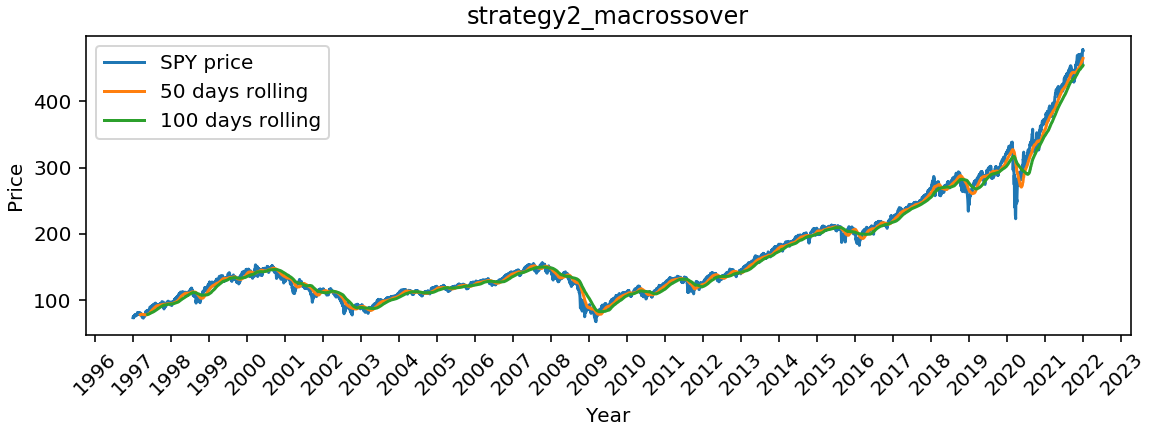
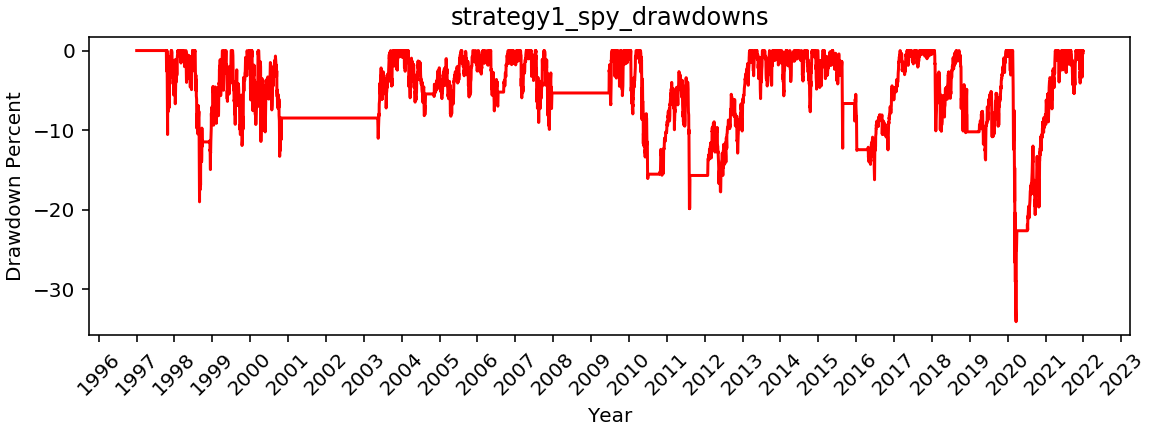
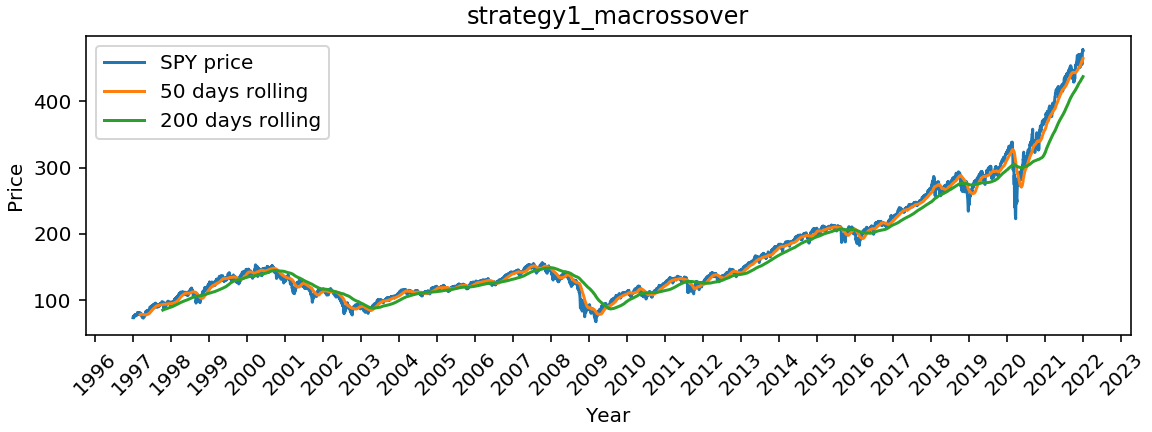
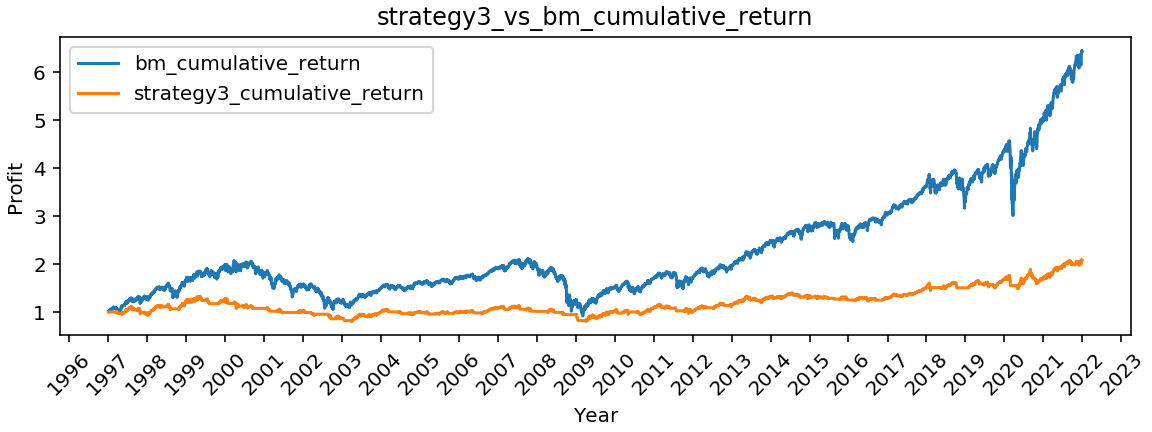
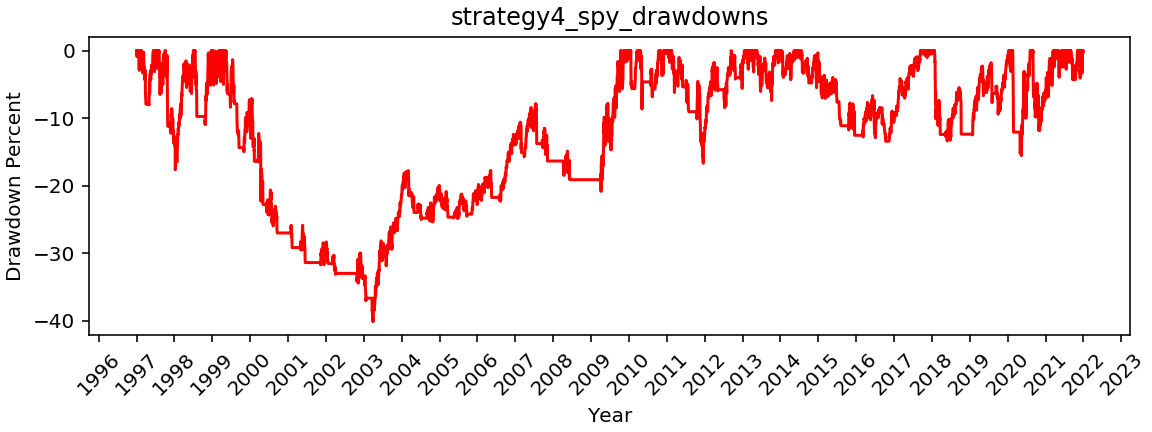
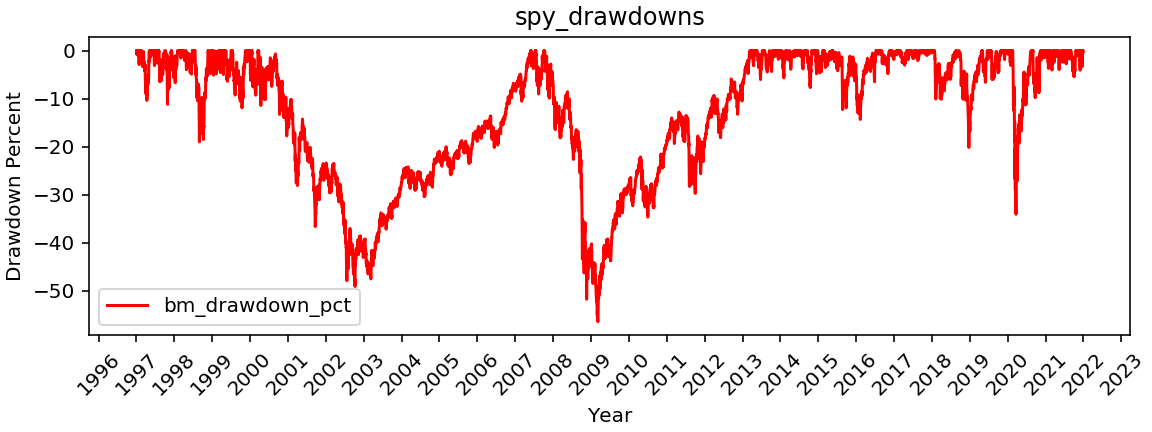
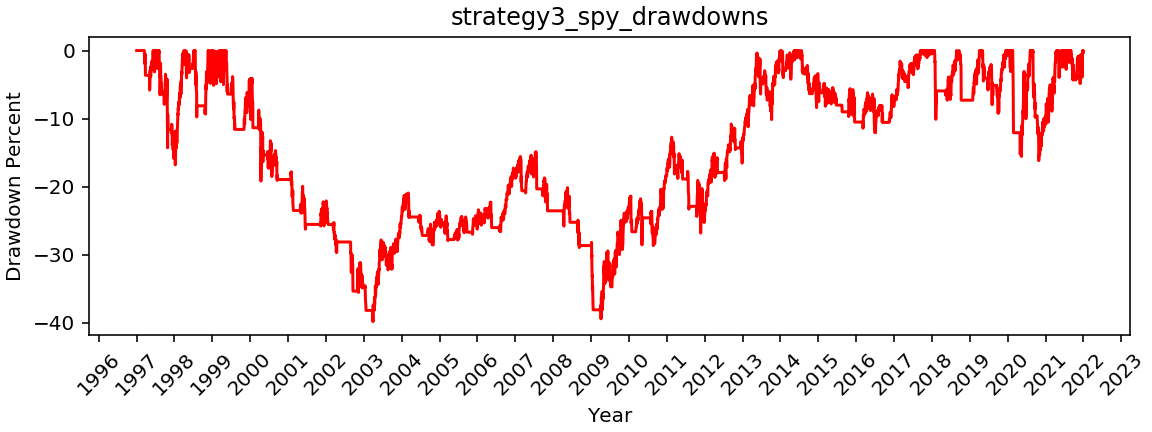
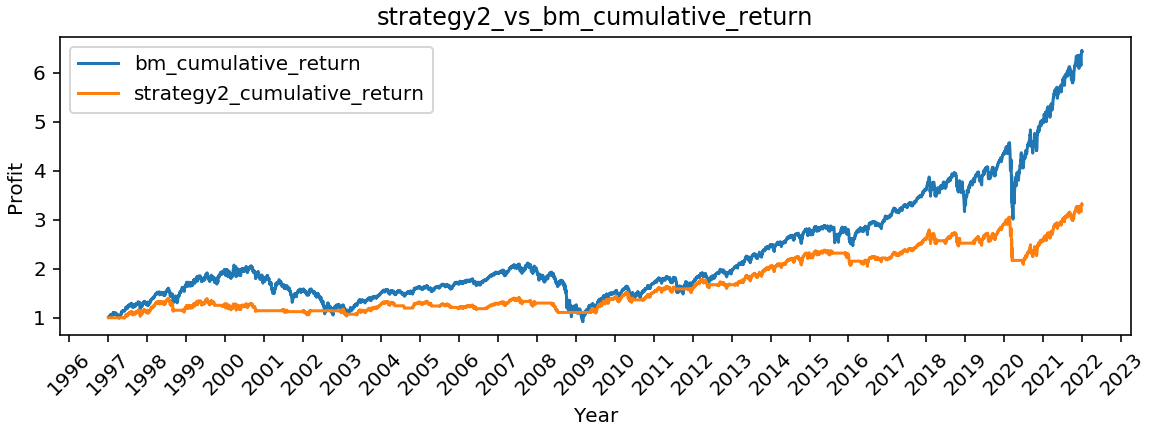
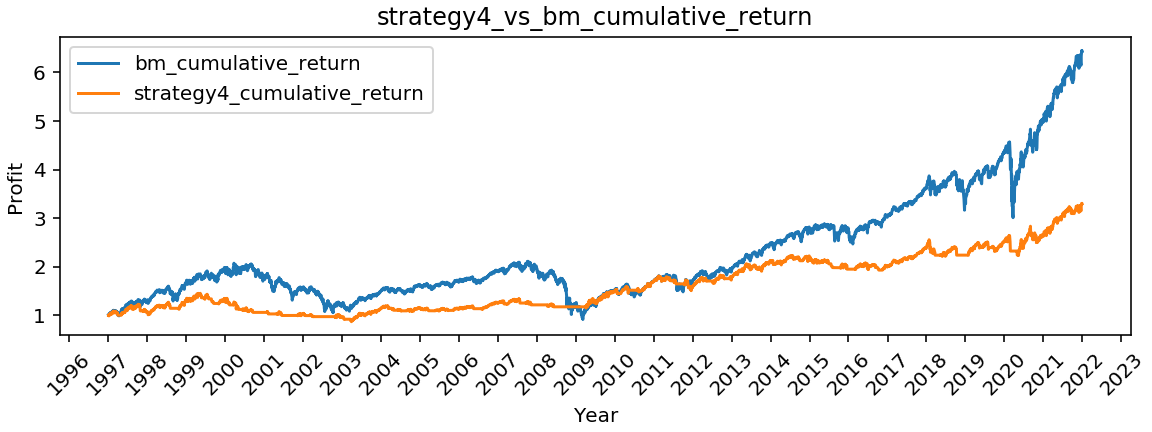
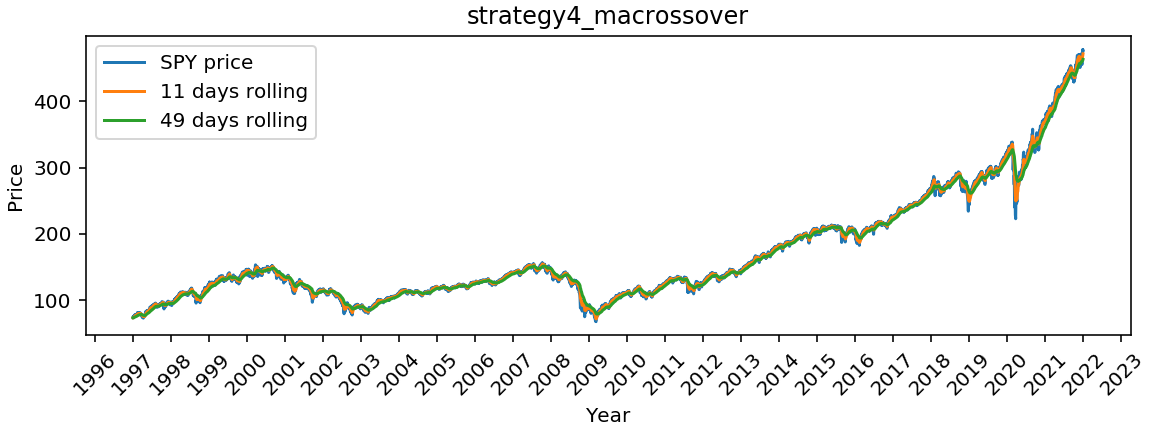
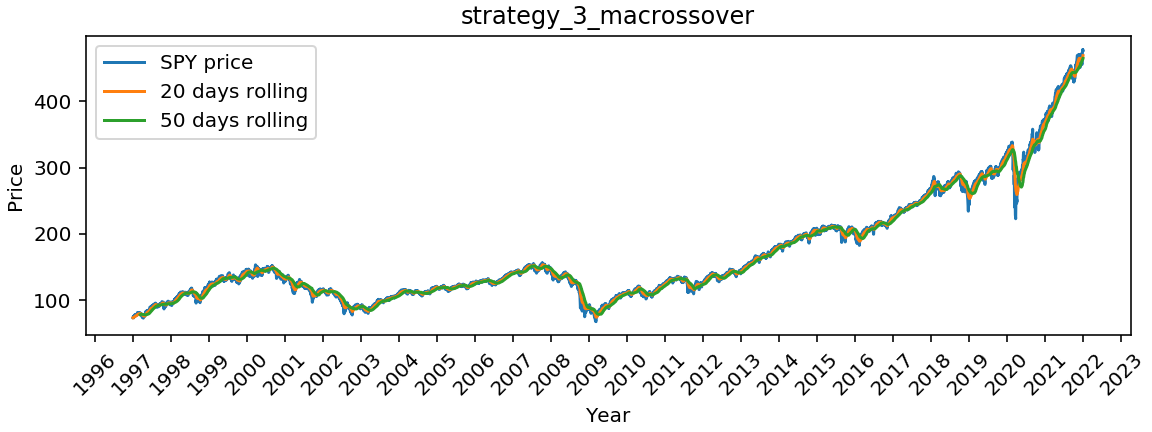
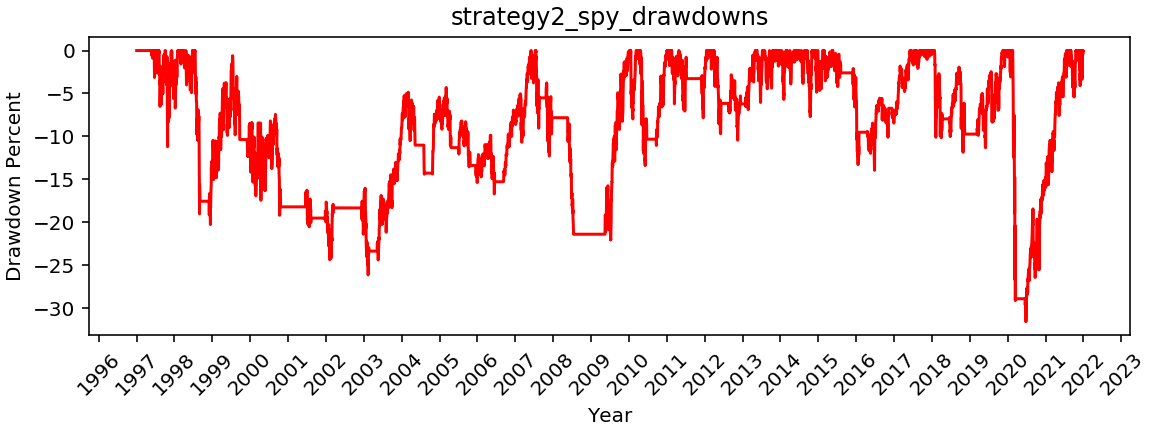
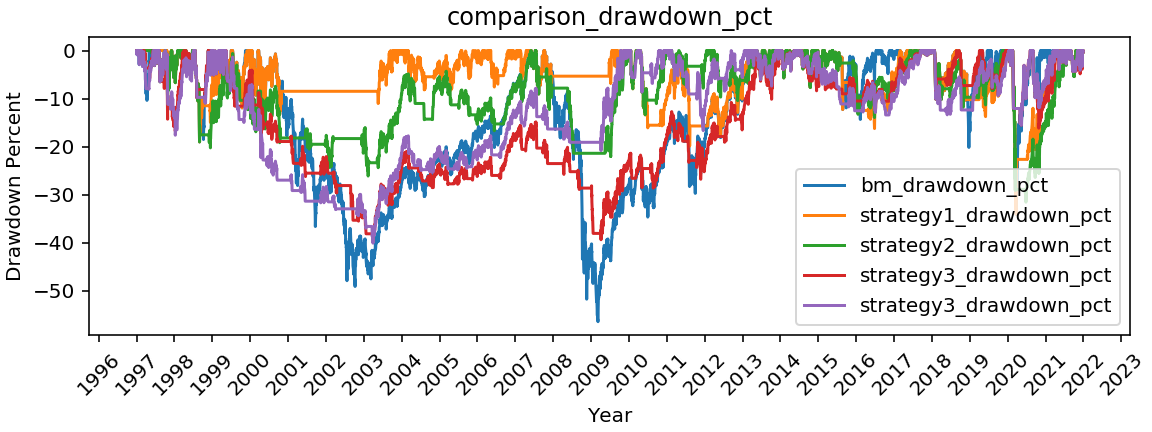
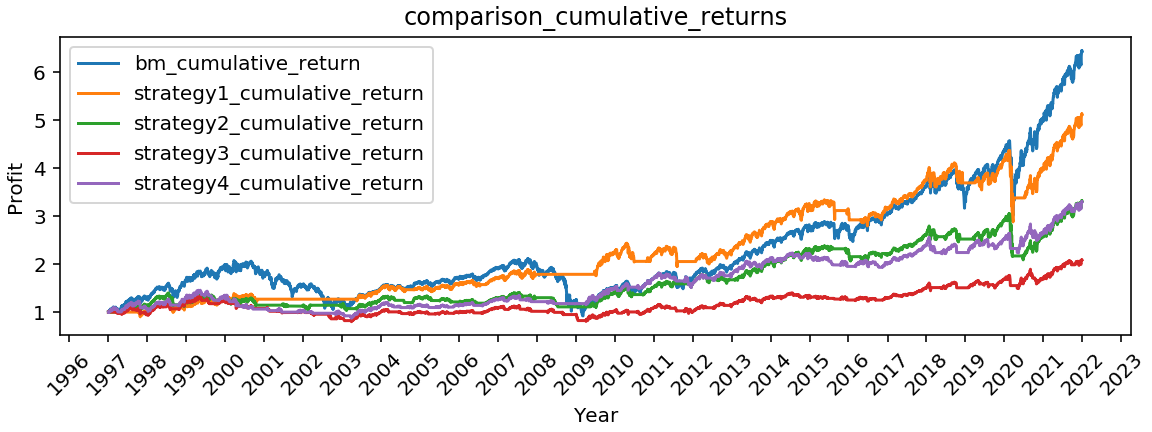
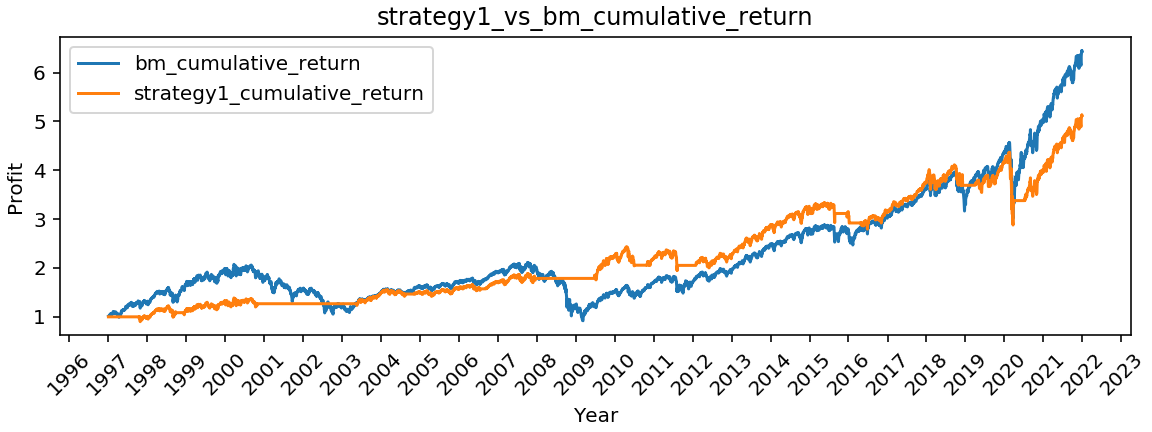
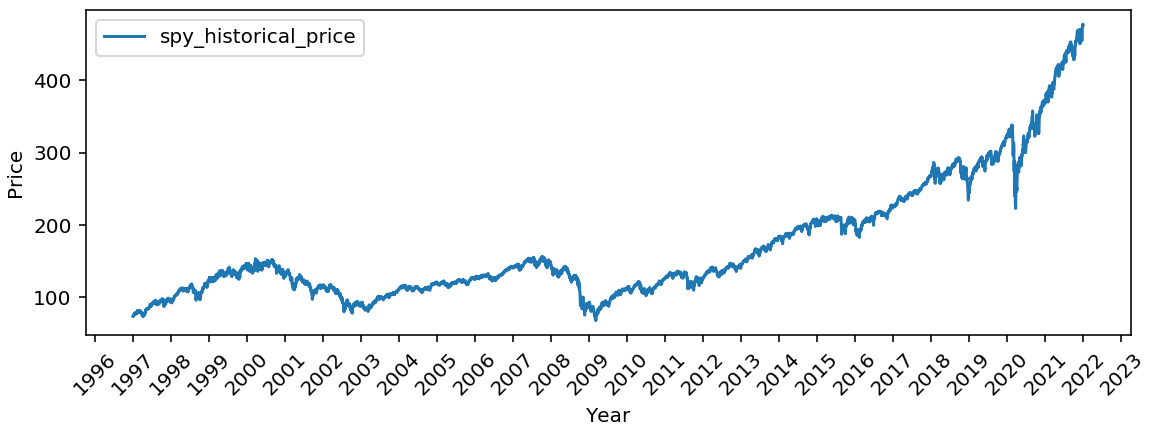

In [120]:
# The strategy plots were already declared as follows:
#strategy1_plot = strategy_plot(strategy1, 'SPY price', '50 days rolling', '200 days rolling',"strategy1_macrossover")
#strategy2_plot = strategy_plot(strategy2, 'SPY price', '50 days rolling', '100 days rolling',"strategy2_macrossover")
#strategy3_plot = strategy_plot(strategy3, 'SPY price', '20 days rolling','50 days rolling',"strategy3_macrossover")
#strategy4_plot = strategy_plot(strategy4, 'SPY price', '11 days rolling', '49 days rolling',"strategy4_macrossover")

# Position strategy plots in separate rows
strategies_row_1 = pn.Row(strategy1_plot)
strategies_row_2 = pn.Row(strategy2_plot)
strategies_row_3 = pn.Row(strategy3_plot)
strategies_row_4 = pn.Row(strategy4_plot)
# Put rows in a column
strategy_analysis_column = pn.Column(strategies_row_1, strategies_row_2, strategies_row_3, strategies_row_4)

# Strategy1 with the benchmark plot
strategy1_with_bm = strategy_return_plot(bm_daily_return, strategy1_return, "strategy1_cumulative_return", "strategy1_vs_bm_cumulative_return")
# Strategy2 with the benchmark plot
strategy2_with_bm = strategy_return_plot(bm_daily_return, strategy2_return, "strategy2_cumulative_return","strategy2_vs_bm_cumulative_return")
# Strategy3 with the benchmark plot  
strategy3_with_bm = strategy_return_plot(bm_daily_return, strategy3_return, "strategy3_cumulative_return","strategy3_vs_bm_cumulative_return")
# Strategy4 with the benchmark plot
strategy4_with_bm = strategy_return_plot(bm_daily_return, strategy4_return, "strategy4_cumulative_return","strategy4_vs_bm_cumulative_return")

# Put strategy with the benchmark plots in a column
strategy_with_bm_column = pn.Column(strategy1_with_bm, strategy2_with_bm, strategy3_with_bm, strategy4_with_bm)

# The strategy daily drawback plots were already declared as follows:
#strategy1_dd = strategy_dd(strategy1_return, "strategy1_drawdown_pct")
#strategy2_dd = strategy_dd(strategy2_return, "strategy2_drawdown_pct")
#strategy3_dd = strategy_dd(strategy3_return, "strategy3_drawdown_pct")
#strategy4_dd = strategy_dd(strategy4_return, "strategy4_drawdown_pct")

# Position strategy daily drawback plots in separate rows
strategies_dd_row_1 = pn.Row(strategy1_dd)
strategies_dd_row_2 = pn.Row(strategy2_dd)
strategies_dd_row_3 = pn.Row(strategy3_dd)
strategies_dd_row_4 = pn.Row(strategy4_dd)
# Put rows in a column
strategy_dd_analysis_column = pn.Column(strategies_dd_row_1, strategies_dd_row_2, strategies_dd_row_3, strategies_dd_row_4)

# Put comparison among different strategies plots in a column
strategies_returns = strategy_comp_return_plot(bm_daily_return, strategy1_return, "strategy1_cumulative_return",strategy2_return, "strategy2_cumulative_return", 
                     strategy3_return, "strategy3_cumulative_return", strategy4_return, "strategy4_cumulative_return", "comparison_cumulative_returns")
# strategies_dd was already declared as follows:
#strategies_dd = strategy_dd("comparison_drawdown_pct")
strategy_comparison_column = pn.Column(strategies_returns, strategies_dd)

# Create the main dashboard
ma_crossover_dashboard_tabs = pn.Tabs(
    (
        "Overview",
        welcome_column
    ),
    (
        "Buy and Hold",
        buy_hold
    ),
    (
        "Strategy Analysis",
        strategy_analysis_column
    ),
    (
        "Strategy With Benchmark Comparison",
        strategy_with_bm_column
    ),
    (
        "Strategy Daily Drawback Comparison",
        strategy_dd_analysis_column
    )

)

ma_crossover_dashboard = pn.Column(title, ma_crossover_dashboard_tabs)

ma_crossover_dashboard